In [33]:
import ee
from drought.data import ee_climate, ee_utils, geo
from drought.visualization import plot
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import importlib
importlib.reload(plot)

<module 'drought.visualization.plot' from '/Users/jovanaknezevic/drought-with-gedi/drought/visualization/plot.py'>

## Prerequisites

Before running the notebook, make sure to authenticate with Google Earth 
Engine. 

You can do so by running ```earthengine authenticate``` on the command line
or uncommenting the authentication cell below. See [here](https://developers.google.com/earth-engine/guides/python_install#authentication) for more details.

### Earth Engine Initialization

In [ ]:
# Uncomment if you want to authenticate within jupyter notebook.
#ee.Authenticate()

In [2]:
ee.Initialize()

## Fetch Climate Data from EE

In [3]:
# Get regions of interest.
ee_geoms = geo.get_ee_polygons()

In [4]:
# Initial date of interest (inclusive).
start_date = ee.Date('2019-01-01')

# Final date of interest (exclusive).
end_date = ee.Date('2023-01-01')

In [5]:
# Fetch stacked climate data.
ee_stack = ee_climate.get_monthly_climate_data(start_date, end_date, ee_geoms)

In [9]:
# Convert the data to pandas DataFrame.
all_polygons_pdfs = []
for i in range(len(ee_geoms)):
    pdf = ee_utils.get_region_as_df(ee_stack, ee_geoms[i], 5000, 
                              ['precipitation', 'temperature', 'radiation'])
    pdf["polygon_id"] = i + 1
    all_polygons_pdfs.append(pdf)
    
climate_pdf = pd.concat(all_polygons_pdfs)

### Average data monthly per polygon and save in a CSV file

In [11]:
monthly_mean = climate_pdf.groupby(['month', 'year', 'polygon_id']) \
                 .mean(numeric_only=True).reset_index()

In [14]:
monthly_mean.to_csv("../../data/interim/climate_r_p_t_monthly_mean_per_polygon_1-2019_to_12-2022.csv")

### Plot total monthly averages

In [15]:
# Calculate monthly mean for all three years in aggregate.
total_monthly_mean = climate_pdf.groupby(['month', 'polygon_id']) \
                                .mean(numeric_only=True).reset_index() \
                                .drop(columns=['year'])

In [17]:
# Palette for plotting. Colors can be accessed by indexing - plot.palette[i]
plot.palette

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

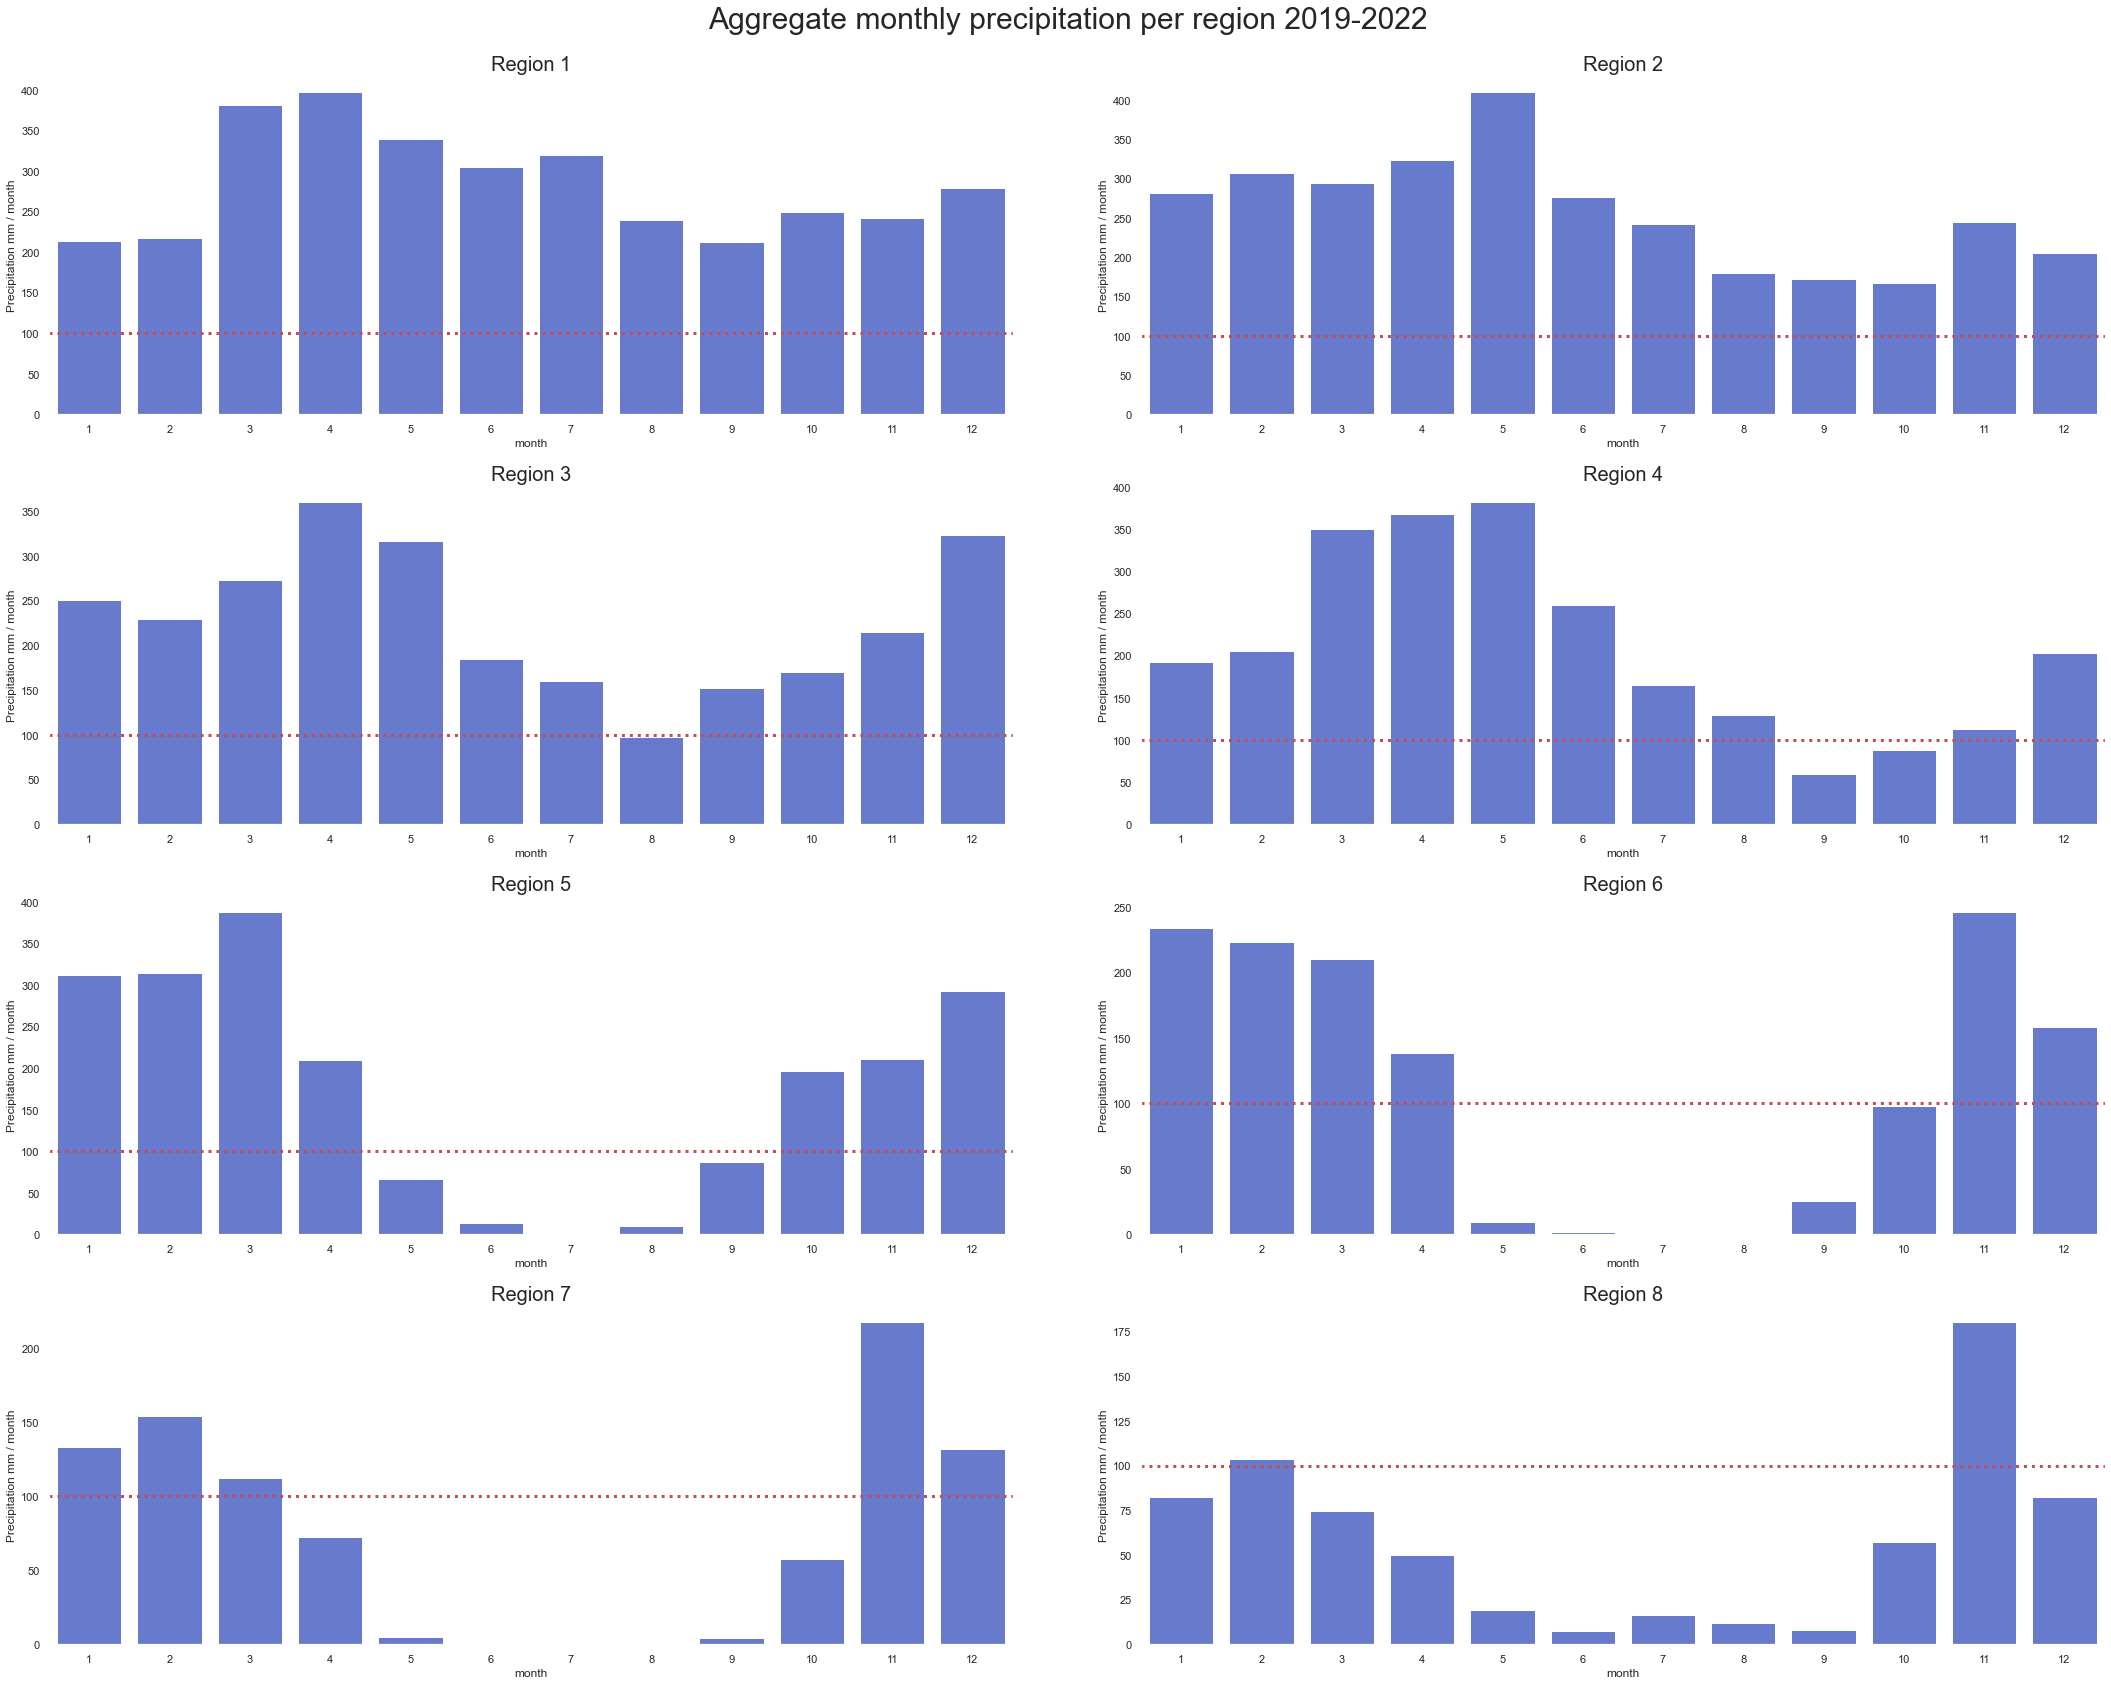

In [34]:
# Plot aggregate monthly precipitation per region.
fig = plot.barplot_per_region(total_monthly_mean, 
                              region_ids=range(1, 9),
                              region_col='polygon_id', 
                              x='month', 
                              y='precipitation', 
                              ylabel="Precipitation mm / month",
                              title="Aggregate monthly precipitation per region 2019-2022",
                              color=plot.palette[5])
# Mark the 100mm precipitation line that signifies a dry month.
[subplot.axhline(y=100, color = 'r', linestyle = 'dotted', linewidth=3) 
 for subplot in fig.get_axes()]
plt.show()

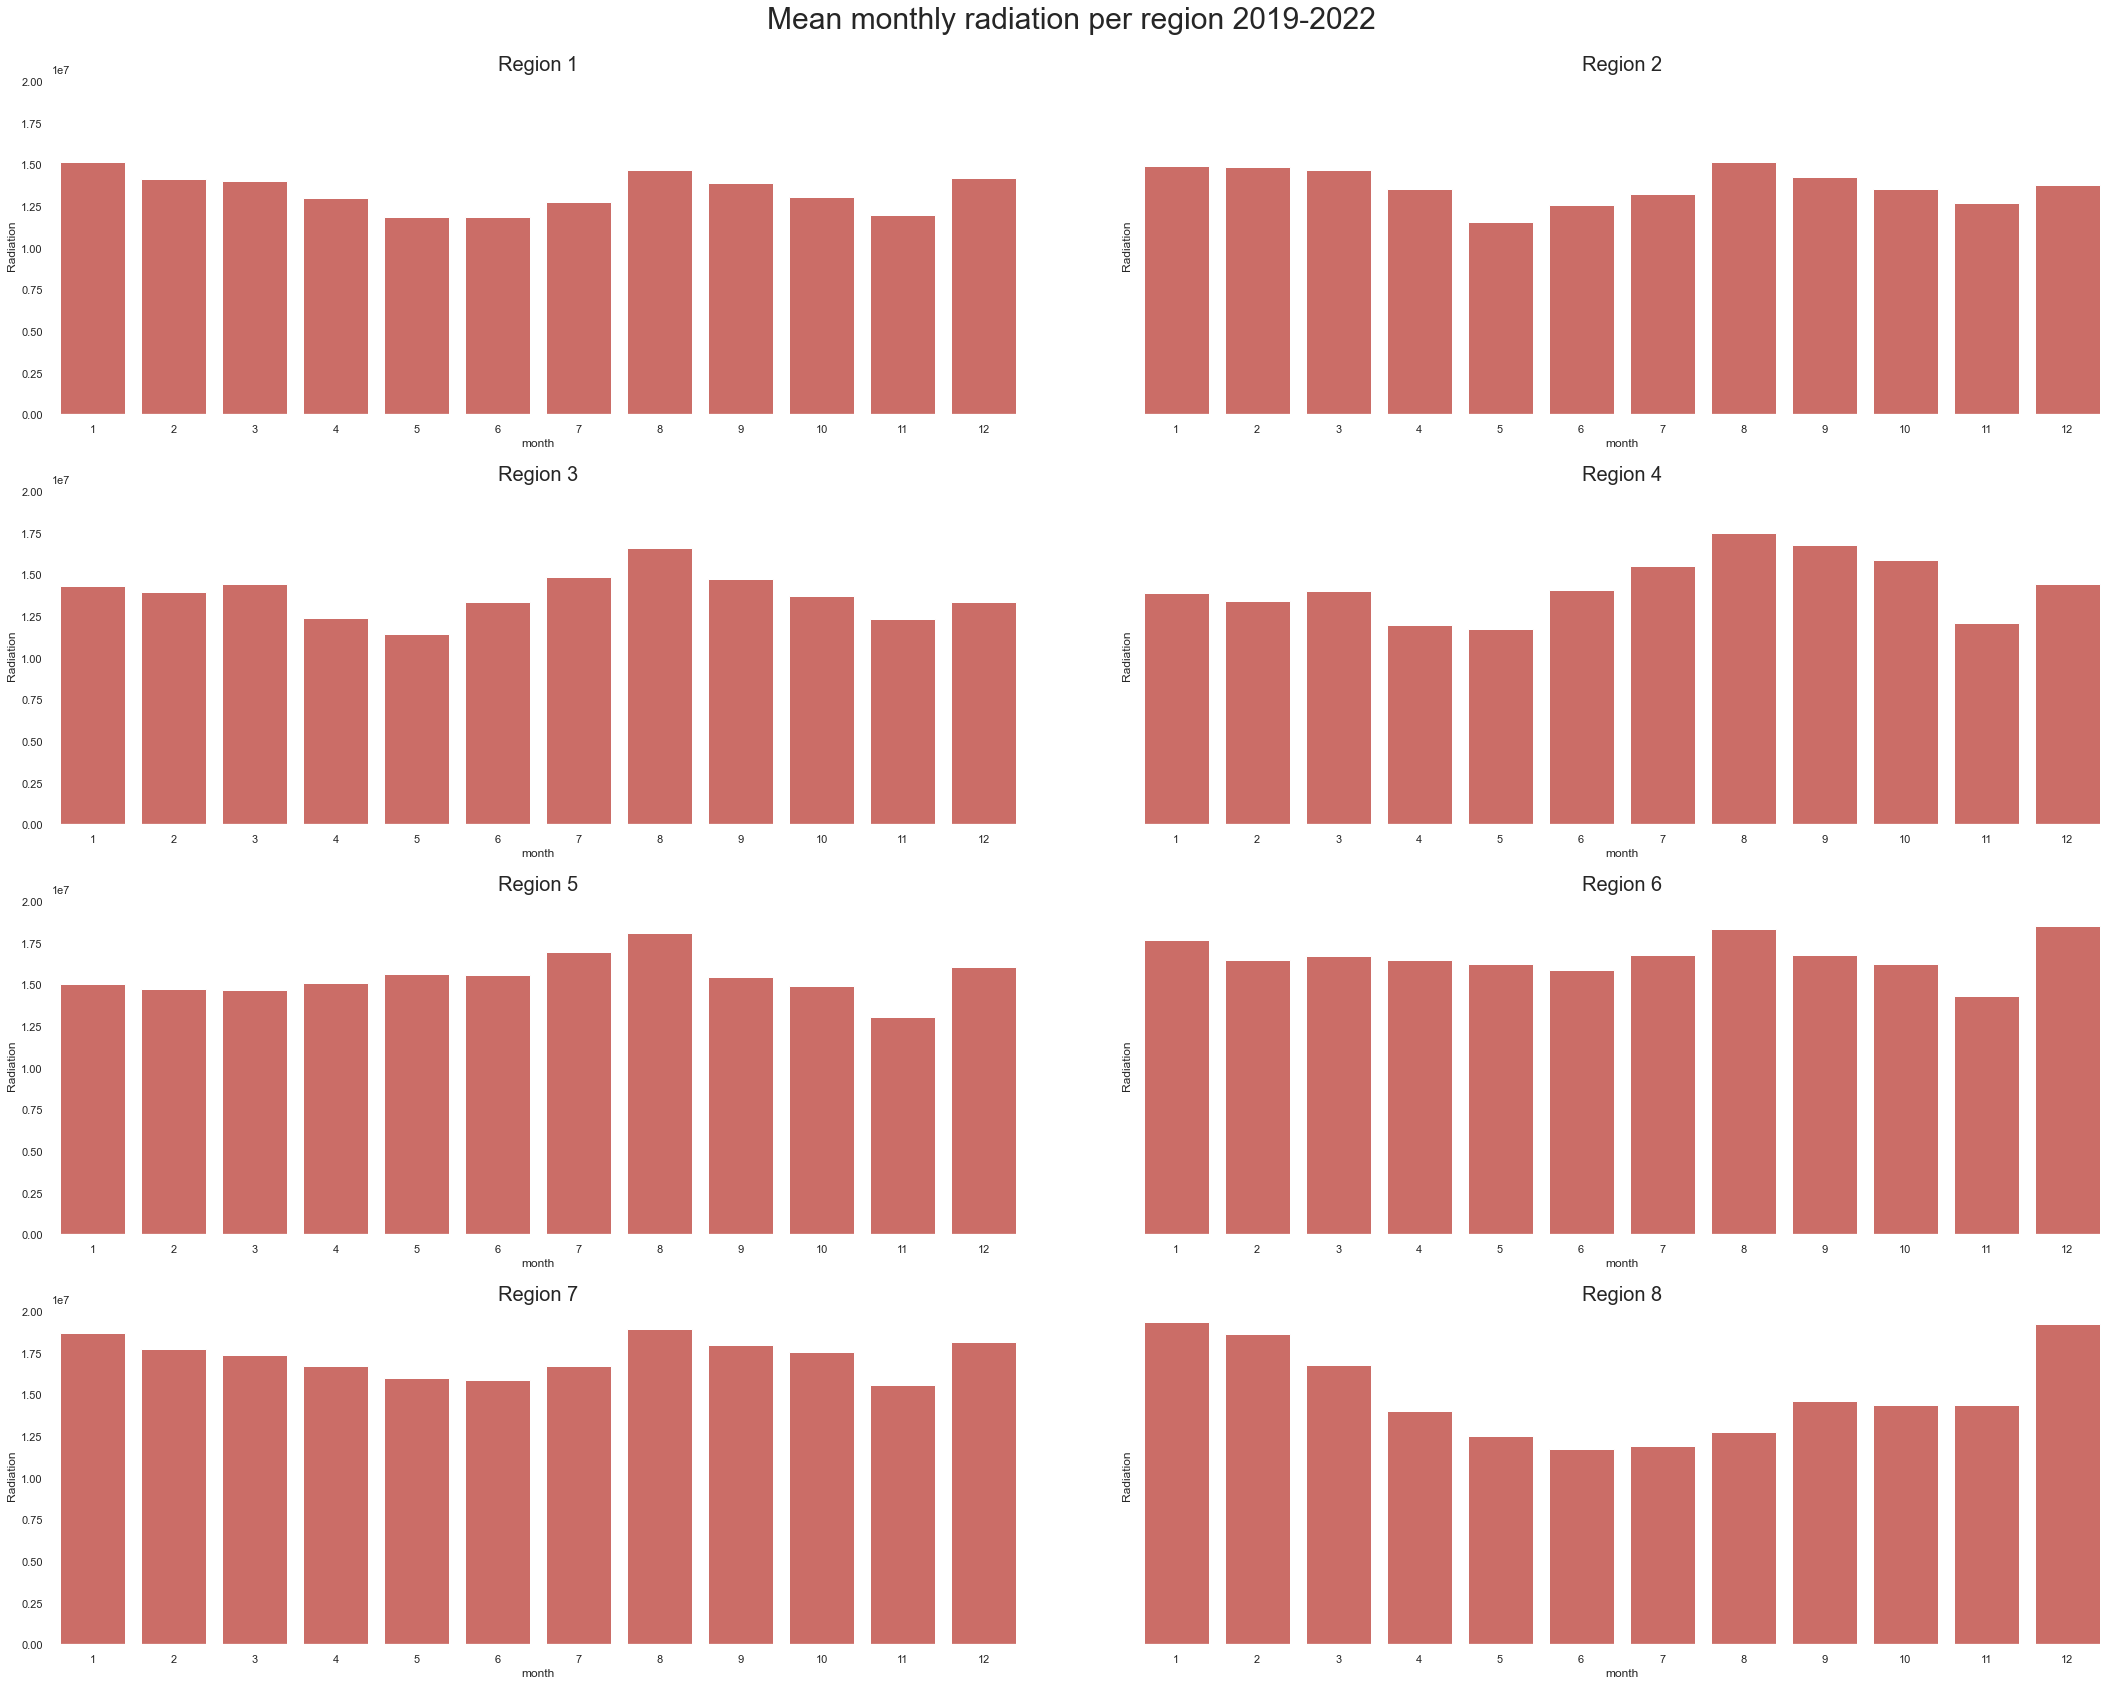

In [35]:
# Plot aggregate monthly radiation per region.
fig = plot.barplot_per_region(total_monthly_mean, 
                              region_ids=range(1, 9),
                              region_col='polygon_id',
                              x='month', 
                              y='radiation', 
                              ylabel="Radiation",
                              title="Mean monthly radiation per region 2019-2022",
                              color=plot.palette[0],
                              sharey=True)
plt.show()

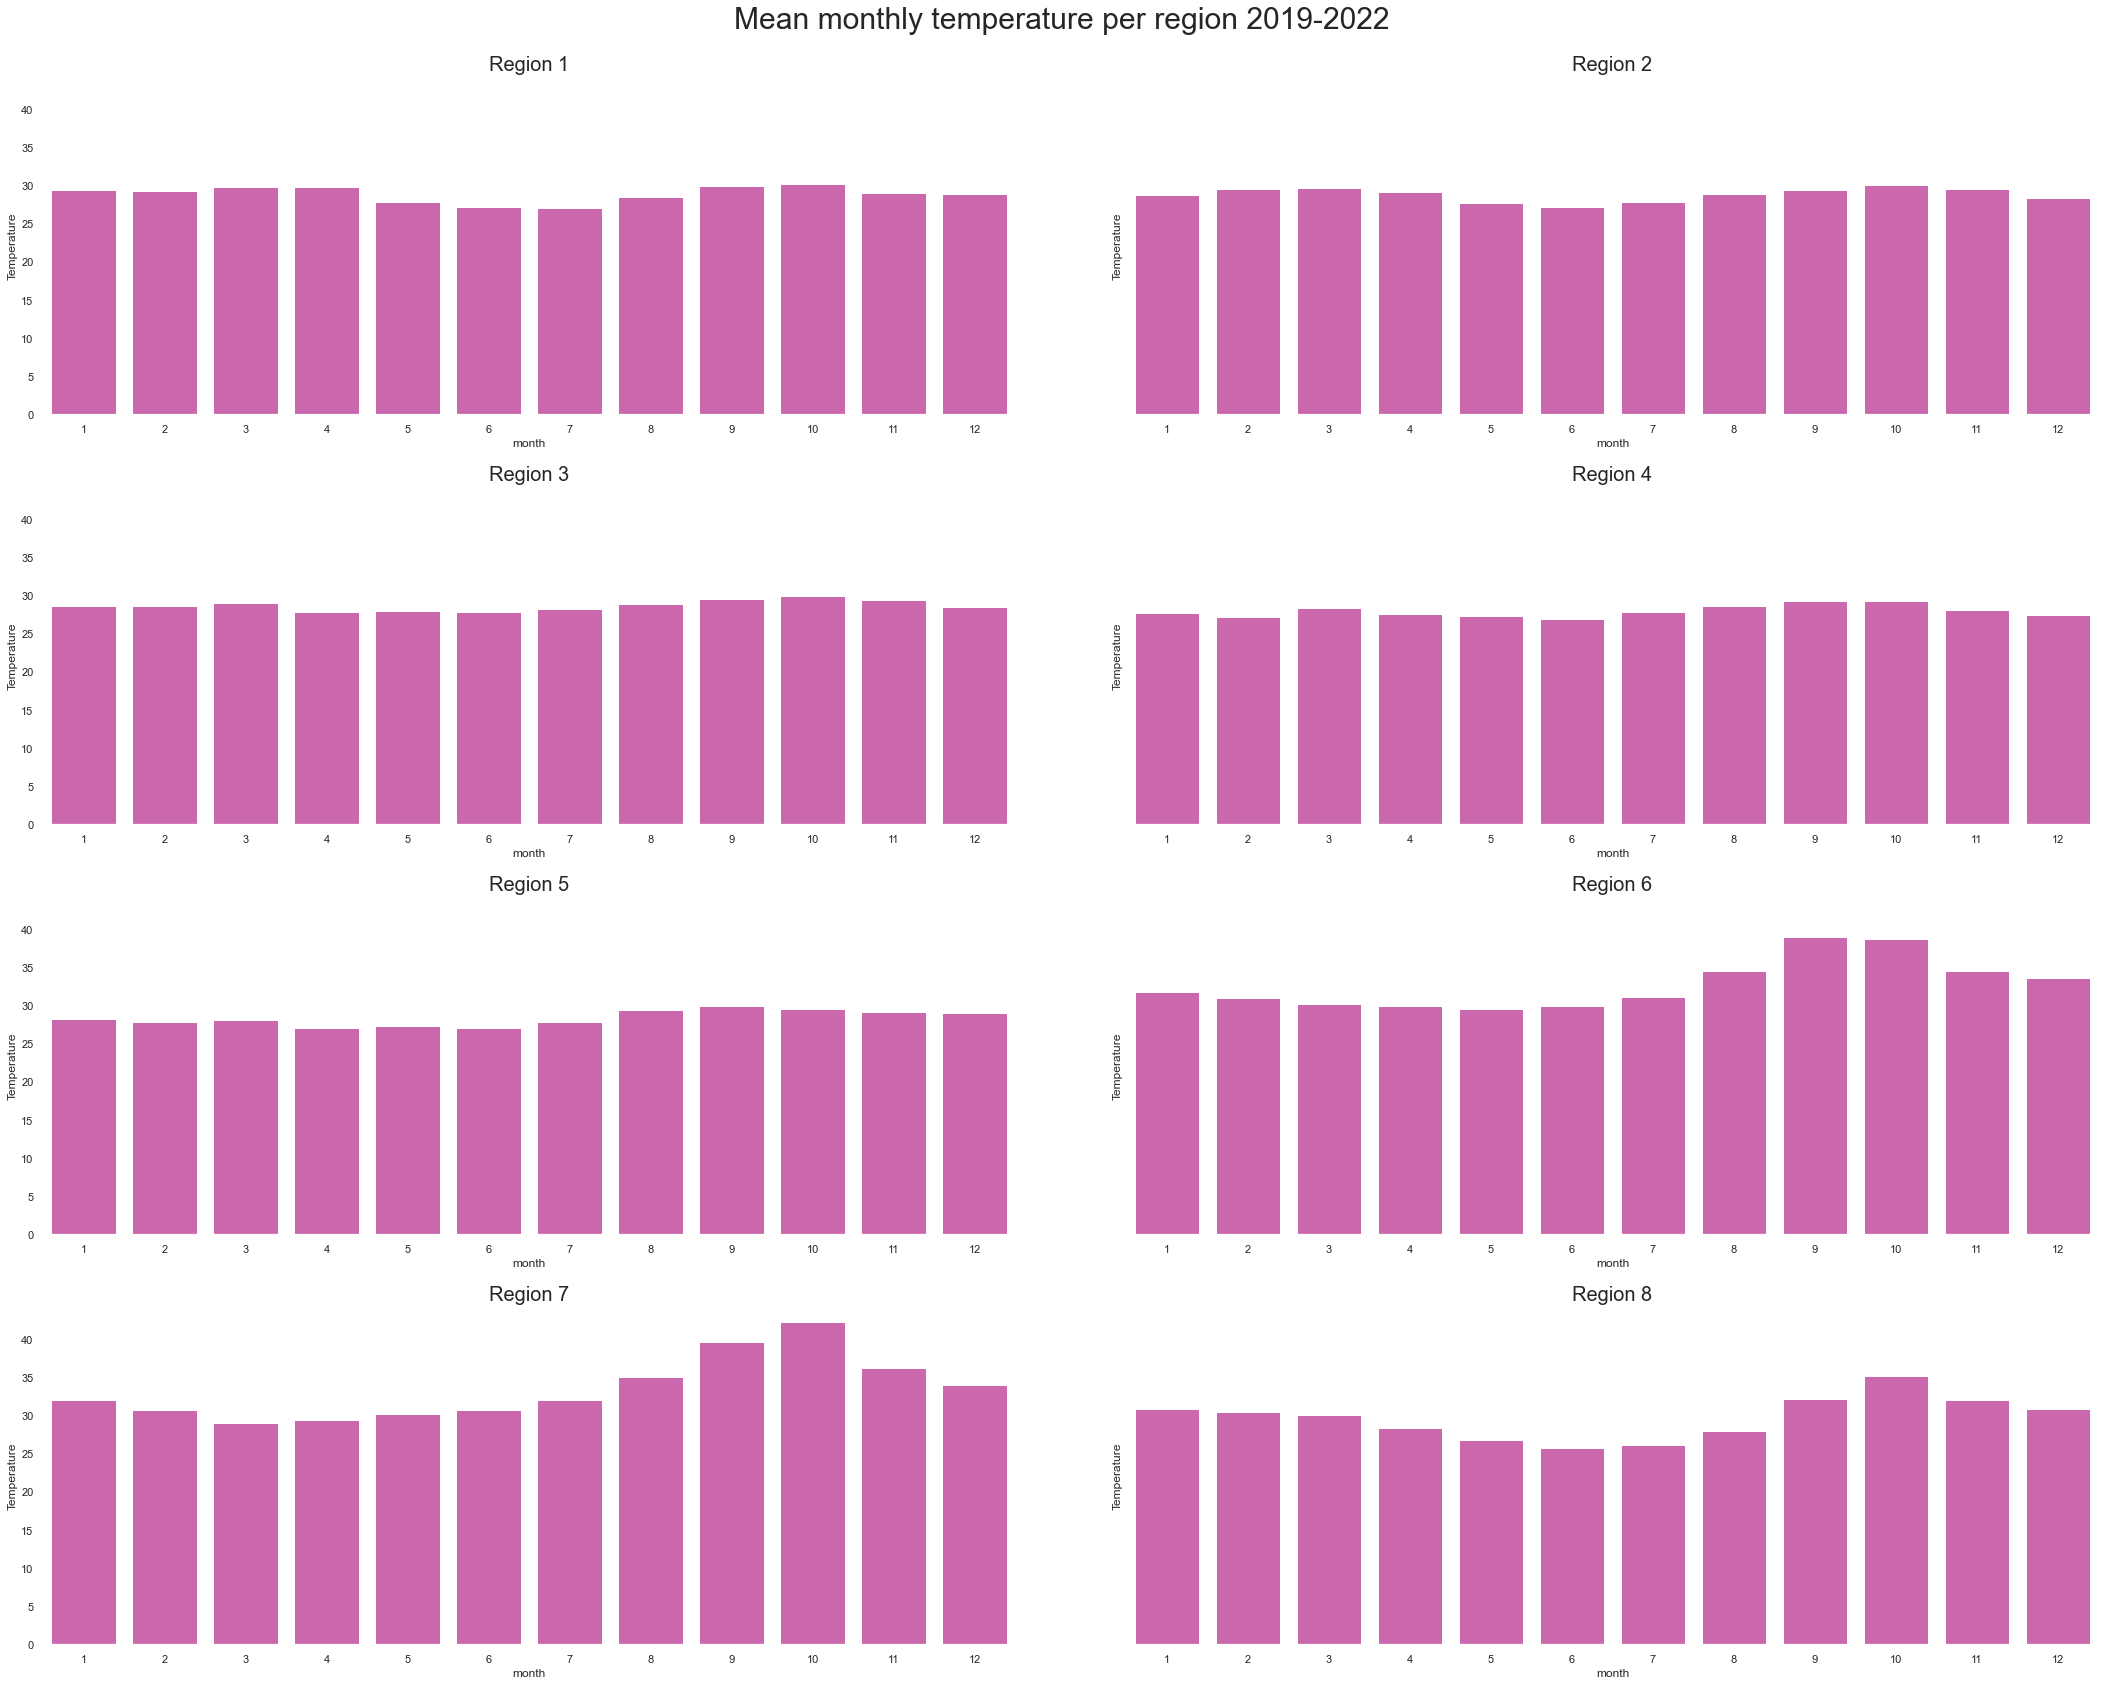

In [36]:
# Plot aggregate monthly temperature per region.
fig = plot.barplot_per_region(total_monthly_mean, 
                              region_ids=range(1, 9),
                              region_col='polygon_id',
                              x='month', 
                              y='temperature', 
                              ylabel="Temperature",
                              title="Mean monthly temperature per region 2019-2022",
                              color=plot.palette[7],
                              sharey=True)
plt.show()